In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union
from sklearn.metrics import *
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from tools import *
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("../data/smoking.csv")
data.drop(["ID", "oral"], axis=1, inplace=True)
data.head()

,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar,smoking
0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,114.0,...,126.0,12.9,1.0,0.7,18.0,19.0,27.0,0,Y,0
1,F,40,160,60,81.0,0.8,0.6,1.0,1.0,119.0,...,127.0,12.7,1.0,0.6,22.0,19.0,18.0,0,Y,0
2,M,55,170,60,80.0,0.8,0.8,1.0,1.0,138.0,...,151.0,15.8,1.0,1.0,21.0,16.0,22.0,0,N,1
3,M,40,165,70,88.0,1.5,1.5,1.0,1.0,100.0,...,226.0,14.7,1.0,1.0,19.0,26.0,18.0,0,Y,0
4,F,40,155,60,86.0,1.0,1.0,1.0,1.0,120.0,...,107.0,12.5,1.0,0.6,16.0,14.0,22.0,0,N,0


In [4]:
#Compressing hearing and eyesight columns for both ears/eyes into one.
data["eyesight"] = (data["eyesight(left)"] + data["eyesight(right)"])/2.0
data["hearing"] = (data["hearing(left)"] + data["hearing(right)"])/2.0
data.drop(['eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)'], axis = 1, inplace = True)

In [5]:
oe = OrdinalEncoder()
categorical_cols = data.select_dtypes(include='object').columns.tolist()
data[categorical_cols] = oe.fit_transform(data[data.select_dtypes(include='object').columns.tolist()]) 
oe.categories_

[array(['F', 'M'], dtype=object), array(['N', 'Y'], dtype=object)]

In [6]:
y = data["smoking"].copy()
X = data.drop("smoking", axis=1).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

## Model I: Wybieramy wszystkie zmienne

In [7]:
lr = LogisticRegression(max_iter=250, solver="liblinear")
lr.fit(X_train, y_train)
model_I = generate_raport(lr, X_train, X_test, y_train, y_test, True)
model_I["Name"]= "Logit_raw"
pd.Series(dict(zip(X_train.columns.tolist(), *lr.coef_.tolist())), name="Współczynniki")

gender                 3.104986
age                   -0.002526
height(cm)            -0.000607
weight(kg)             0.003527
waist(cm)             -0.015214
systolic              -0.016531
relaxation             0.009324
fasting blood sugar    0.002743
Cholesterol           -0.002765
triglyceride           0.004723
HDL                    0.000603
LDL                   -0.000166
hemoglobin             0.111009
Urine protein         -0.018169
serum creatinine      -0.857501
AST                   -0.001628
ALT                   -0.005420
Gtp                    0.008061
dental caries          0.330297
tartar                 0.326147
eyesight              -0.059243
hearing               -0.357715
Name: Współczynniki, dtype: float64

In [8]:
logit_model = sm.Logit(y_train, sm.add_constant(X_train)).fit()
print(logit_model.summary())

# results = logit_model.predict(X_test)
# results = np.where(results<.5,0,1)

Optimization terminated successfully.
         Current function value: 0.470661
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                smoking   No. Observations:                44553
Model:                          Logit   Df Residuals:                    44530
Method:                           MLE   Df Model:                           22
Date:                Sun, 20 Nov 2022   Pseudo R-squ.:                  0.2839
Time:                        22:55:23   Log-Likelihood:                -20969.
converged:                       True   LL-Null:                       -29282.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -6.4133      0.480    -13.348      0.000      -7.355      -5.472
ge

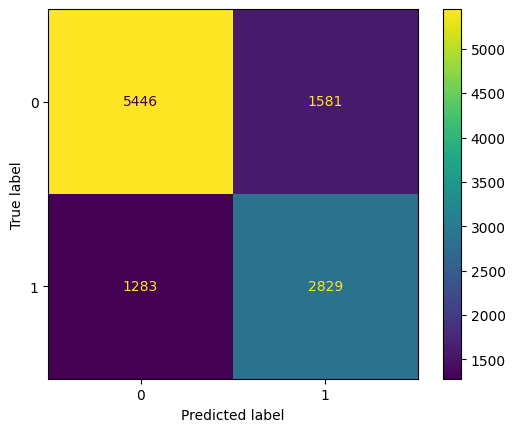

In [9]:
plot_confusion_matrix(lr, X_test, y_test)

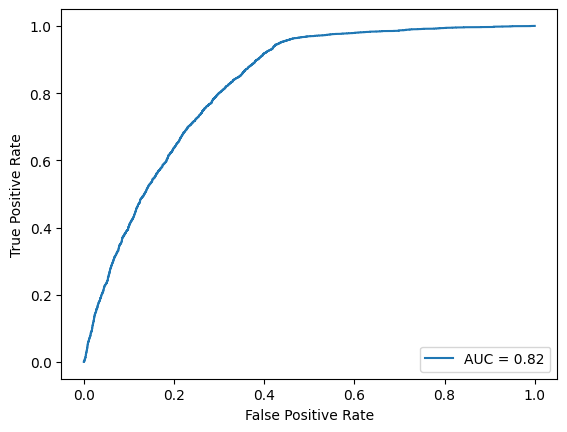

In [10]:
plot_roc_auc(lr, X_test, y_test).plot()

## Model II z usuniętymi nieistotnymi zmiennymi

In [24]:
logit_model = sm.Logit(y_train, sm.add_constant(X_train.drop(["HDL", "LDL", "Urine protein", "AST", "eyesight", "age", "waist(cm)"], axis=1))).fit()
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.470748
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                smoking   No. Observations:                44553
Model:                          Logit   Df Residuals:                    44537
Method:                           MLE   Df Model:                           15
Date:                Sun, 20 Nov 2022   Pseudo R-squ.:                  0.2838
Time:                        22:58:11   Log-Likelihood:                -20973.
converged:                       True   LL-Null:                       -29282.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -6.6140      0.407    -16.251      0.000      -7.412      -5.816
ge

# Model III z zestandaryzowanymi zmiennymi

In [12]:
tmp = X_train.drop(["HDL", "LDL", "Urine protein", "AST", "eyesight", "age", "waist(cm)"], axis=1)

tmp[categorical_cols]
tmp.loc[:, ~tmp.columns.isin(categorical_cols)] = MinMaxScaler().fit_transform(tmp.loc[:, ~tmp.columns.isin(categorical_cols)])

logit_model = sm.Logit(y_train, sm.add_constant(tmp)).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.470723
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                smoking   No. Observations:                44553
Model:                          Logit   Df Residuals:                    44534
Method:                           MLE   Df Model:                           18
Date:                Sun, 20 Nov 2022   Pseudo R-squ.:                  0.2838
Time:                        22:55:25   Log-Likelihood:                -20972.
converged:                       True   LL-Null:                       -29282.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -4.1265      0.145    -28.391      0.000      -4.411      -3.842
ge

# Model IV Wybranie zmiennych z największą(najbardziej odległą od 0) korelacją

In [13]:
X_train_lr = X_train[["gender", "hemoglobin", "serum creatinine", "Gtp", "triglyceride"]].copy()
X_test_lr = X_test[["gender", "hemoglobin", "serum creatinine", "Gtp", "triglyceride"]].copy()
y_train_lr = y_train.copy()
y_test_lr = y_test.copy()

In [14]:
lr = LogisticRegression()
lr.fit(X_train_lr, y_train_lr)
model_IV = generate_raport(lr, X_train_lr, X_test_lr, y_train_lr, y_test_lr, True)
model_IV["Name"]= "Logit 4 variables"
model_IV

,Precision,Recall,F1 Score,Accuracy,Roc_auc_score,Name
0,0.618804,0.677043,0.646615,0.726816,0.810852,Logit 4 variables


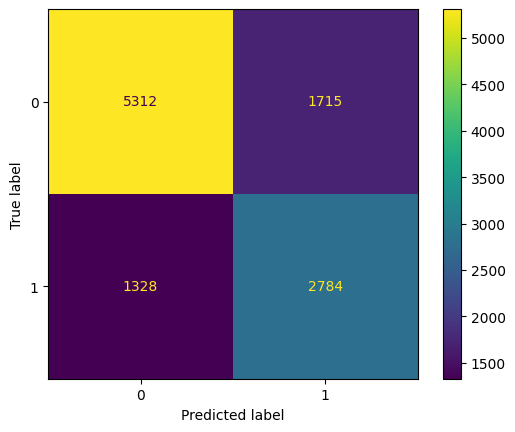

In [15]:
plot_confusion_matrix(lr, X_test_lr, y_test_lr)

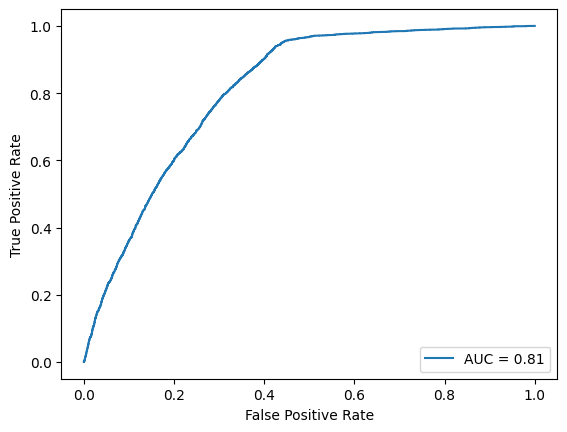

In [16]:
plot_roc_auc(lr, X_test_lr, y_test_lr).plot()

Porównanie modeli poprzez pseudoR2

## Model V regresja logistzcyna z regularyzacją

In [17]:
ss = StandardScaler()
# ss = MinMaxScaler()
X_train_lr.loc[:,~X_train_lr.columns.isin(categorical_cols)] = ss.fit_transform(X_train_lr.loc[:,~X_train_lr.columns.isin(categorical_cols)])
X_test_lr.loc[:,~X_test_lr.columns.isin(categorical_cols)] = ss.fit_transform(X_test_lr.loc[:,~X_test_lr.columns.isin(categorical_cols)])

In [18]:
lr = LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=.5)
lr.fit(X_train_lr, y_train_lr)
model_V = generate_raport(lr, X_train_lr, X_test_lr, y_train_lr, y_test_lr, True)
model_V["Name"] = "Logit_4_vars+reg"
model_V

,Precision,Recall,F1 Score,Accuracy,Roc_auc_score,Name
0,0.61773,0.689689,0.651729,0.727893,0.81087,Logit_4_vars+reg


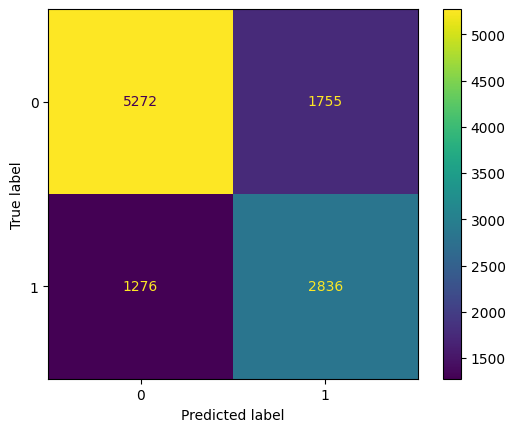

In [19]:
plot_confusion_matrix(lr, X_test_lr, y_test_lr)

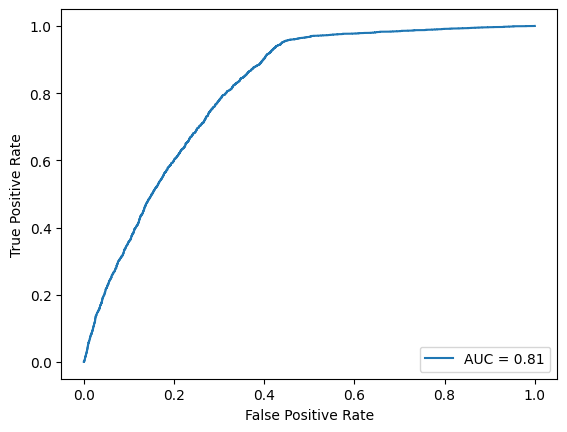

In [20]:
plot_roc_auc(lr, X_test_lr, y_test_lr).plot()

In [21]:
pd.concat([model_I, model_IV, model_V])

,Precision,Recall,F1 Score,Accuracy,Roc_auc_score,Name
0,0.641497,0.687986,0.663929,0.742885,0.823637,Logit_raw
0,0.618804,0.677043,0.646615,0.726816,0.810852,Logit 4 variables
0,0.617730,0.689689,0.651729,0.727893,0.810870,Logit_4_vars+reg


### Model z CV

In [22]:
lr = LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=.5)
lr.fit(X_train_lr, y_train_lr)
model_V = generate_raport(lr, X_train_lr, X_test_lr, y_train_lr, y_test_lr, True)
model_V["Name"] = "Model V"
model_V

,Precision,Recall,F1 Score,Accuracy,Roc_auc_score,Name
0,0.61773,0.689689,0.651729,0.727893,0.810869,Model V


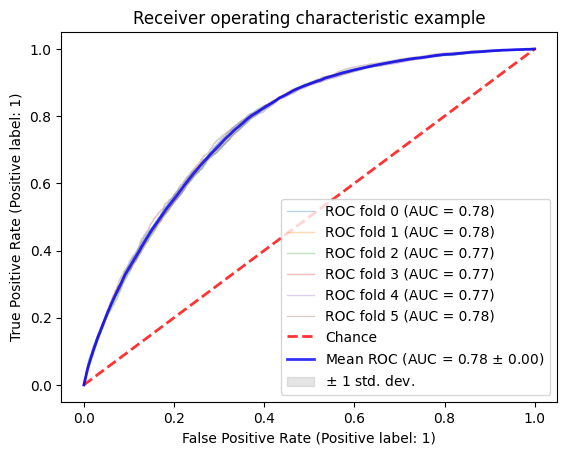

In [23]:
from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
lr = LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=.5, max_iter=100)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    lr.fit(X.loc[train, :], y[train])
    viz = RocCurveDisplay.from_estimator(
        lr,
        X.loc[test, :],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()
